<div style="background-color:#ddecfc; color:#100; padding:30px; border-radius:50px; max-width:1200px; margin:left;">

# Feature Engineering



- feature enrichment
- Preparing scales for modeling 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
%matplotlib inline

## <font color='Navy'> <h4>🔷 <u> Functions </u></h4>
- useful functions called along the code.

In [3]:
def plot_categorical(df, feature, target="is_fraud"):
    # Group by profile and sum the frauds (1 means fraud)
    fraud_by_feature = df.groupby(feature)[target].sum()

    # Calculate the total number of transactions per profile
    total_transactions_by_feature = df.groupby(feature).size()

    # Calculate the percentage of fraud transactions for each profile
    fraud_percentage_by_feature = (fraud_by_feature / total_transactions_by_feature) * 100

    # Sort by the number of fraud cases in ascending order``
    fraud_by_feature = fraud_by_feature.sort_values(ascending=True)
    fraud_percentage_by_feature = fraud_percentage_by_feature[fraud_by_feature.index]
    
    # Set up the subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f'Fraud Analysis by {feature}', fontsize=16, fontweight='bold')

    # Plot 1: Fraud count by profile
    sns.barplot(x=fraud_by_feature.index, y=fraud_by_feature.values, palette='viridis', ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel(f'Number of Fraud Cases', fontsize=12)
    axes[0].set_title(f'Fraud Count by {feature}', fontsize=14)
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].grid(axis='y', linestyle='-', alpha=0.7)

    # Plot 2: Fraud percentage by profile
    sns.barplot(x=fraud_percentage_by_feature.index, y=fraud_percentage_by_feature.values , palette='coolwarm', ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Fraud Percentage (%)', fontsize=12)
    axes[1].set_title(f'Fraud Percentage by {feature}', fontsize=14)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(axis='y', linestyle='-', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


In [4]:
def plot_fraud_rate_by_bin(df, feature):
    """
    Plots fraud rate by quantile bins of a specified feature.
    """

    df[f"{feature}_bin"] = pd.qcut(df[feature], q=10, duplicates="drop")

    fraud_rate_by_bin = (
        df.groupby(f"{feature}_bin")
        .agg(fraud_rate=("is_fraud", "mean"),
            count=("is_fraud", "size"))
        .reset_index()
    )

    fig, ax1 = plt.subplots(figsize=(10, 4))

    sns.lineplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="fraud_rate",
        marker="o",
        color="blue",
        ax=ax1
    )
    ax1.set_ylabel("Fraud Rate", color="blue")
    ax1.set_xlabel(f"{feature.title()} (Quantile Bin)")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Add volume as bars
    ax2 = ax1.twinx()
    sns.barplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="count",
        alpha=0.3,
        color="gray",
        ax=ax2
    )
    ax2.set_ylabel("Transaction Count", color="gray")

    plt.title(f"Fraud Rate by {feature.title()} (Quantile Bins)")
    plt.tight_layout()
    plt.show()

In [5]:
# enriching df with new features based on cc_num
# get credit card company from cc_num
def get_cc_company(cc_num):
    cc_num_str = str(cc_num)
    if re.match(r'^4[0-9]{12}(?:[0-9]{3})?$', cc_num_str):
        return 'Visa'
    elif re.match(r'^5[1-5][0-9]{14}$', cc_num_str):
        return 'MasterCard'
    elif re.match(r'^3[47][0-9]{13}$', cc_num_str):
        return 'American Express'
    elif re.match(r'^6(?:011|5[0-9]{2})[0-9]{12}$', cc_num_str):
        return 'Discover'
    elif re.match(r'^(352[89]|35[3-8][0-9])[0-9]{12}$', cc_num_str):
        return 'JCB'
    elif re.match(r'^(5018|5020|5038|6304|6759|6761|6763)[0-9]{8,15}$', cc_num_str):
        return 'Maestro'
    elif re.match(r'^(34|37)[0-9]{13}$', cc_num_str):
        return 'Diners Club'
    elif re.match(r'^(220[0-4]|2[2-7][0-9]{2})[0-9]{12}$', cc_num_str):
        return 'MIR'
    elif re.match(r'^(5019)[0-9]{12}$', cc_num_str):
        return 'Dankort'
    elif re.match(r'^(6304|6706|6771|6709)[0-9]{12,15}$', cc_num_str):
        return 'Laser'
    else:
        return 'Other'
    

## <font color='Navy'> <h4>🔷 <u> Data Load & Prep </u></h4>

In [6]:
df = pd.read_pickle("Data_Cleansed.pkl")

Featue Engineering:
- Addition of new columns combinations

In [15]:
# Enriching the dataframe based on EDA results

#from KW analysis- we found that `amt` is highly correlated with `hour`, `day`, and `month`:

df['amt_by_hour'] = df['amt'] * (df["trans_hour"].astype('int64') / 24)
df['amt_by_dayofweek'] = df['amt'] * (df['trans_dayofweek'].astype('int64') / 6)
df['amt_by_month'] = df['amt'] * (df['trans_month'].astype('int64') / 12)

his one actually does make sense to test, and your EDA supports it:

Remember the Kruskal–Wallis results? amt and city_pop both had strong links with several categorical variables.

And your fraud-rate plots showed fraud concentrated in smaller populations, but with amt also varying widely.

That suggests there might be an interaction effect between how large the city is and how large the transaction is.

💡 Intuition

Think of it like this:

A $3000 transaction in a city of 30,000 people might stand out more (rarer behavior).

A $3000 transaction in a city of 3 million might be typical.

So a ratio or scaled relationship between amt and city_pop can reflect that “rarity” or “relative spending power.”

In [17]:
df["amt_to_citypop_ratio"] = df["amt"] / (df["city_pop"] + 1)

In [ ]:
df['trans_time']

## <font color='Navy'> <h4>🔷 <u> Feature Enrichment </u></h4>

Feature Engineering and enrichment is needed

- improve model predictive power (better ROC, recall, precision)
- reduce the model’s need to learn very complex patterns from scratch.

To avoid 'Data Leakage' we will not be using anything related to the target 'feature' `is_fraud`
such as 'fature fraud rates' which we used to investigate the data in EDA.
also, anything related to "future information" such as frequencies must be carfully avoided. 

In [43]:
df['cc_company'] = df['cc_num'].apply(get_cc_company)

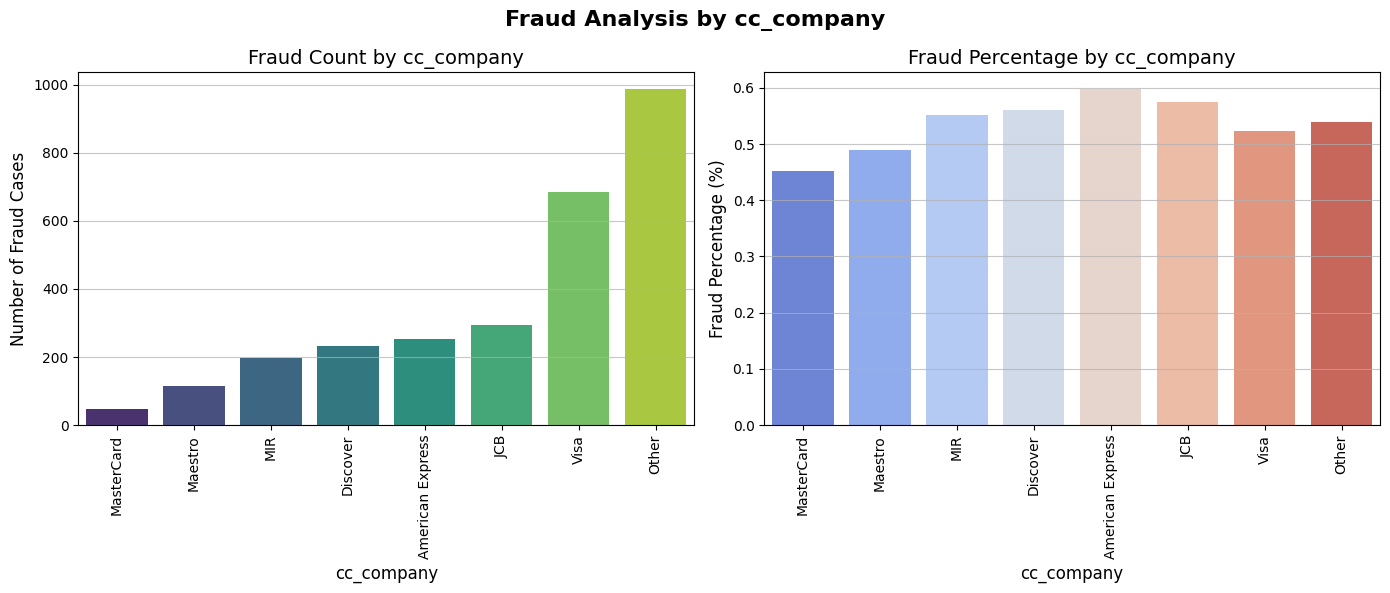

In [22]:
plot_categorical(df, 'cc_company')

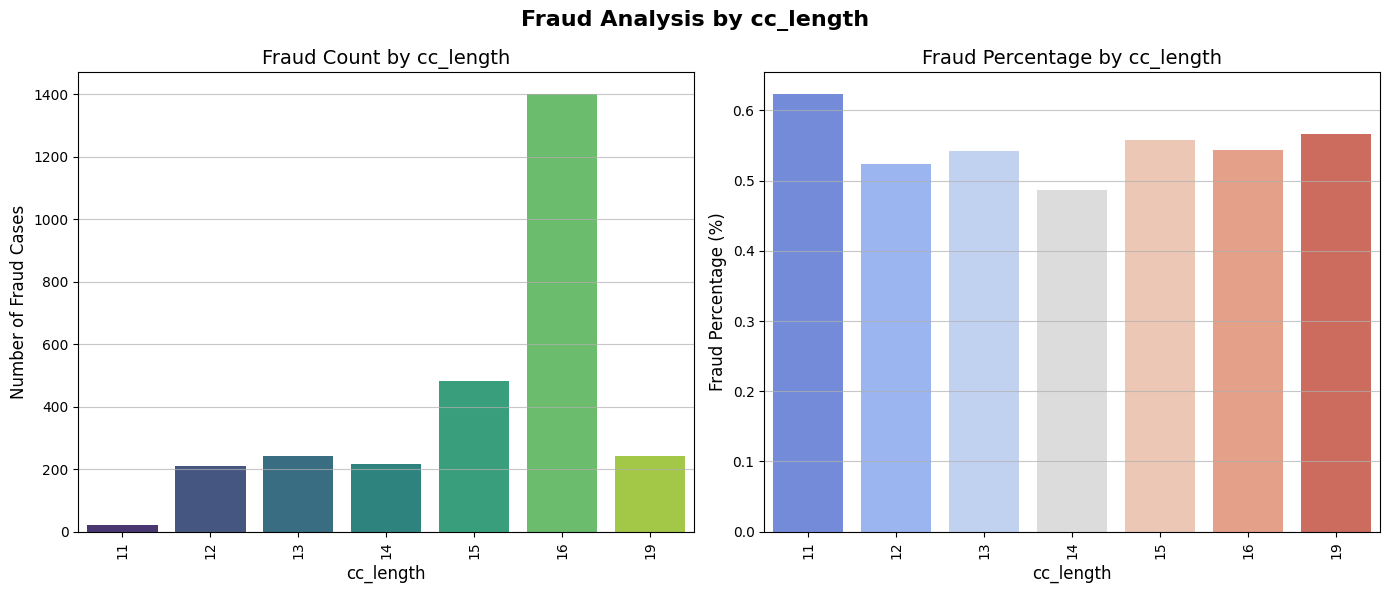

In [46]:
df['cc_length'] = df['cc_num'].astype(str).str.len()
plot_categorical(df, 'cc_length')

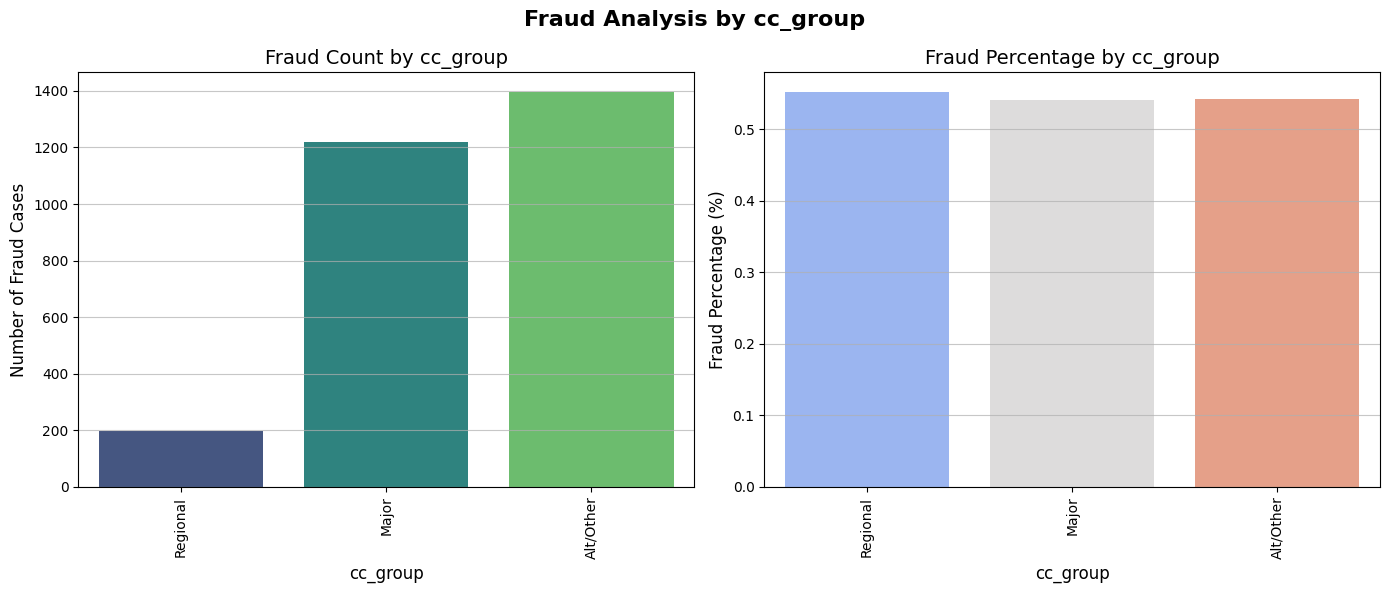

In [56]:
df['cc_group'] = df['cc_company'].replace({
    'Visa': 'Major',
    'MasterCard': 'Major',
    'American Express': 'Major',
    'Discover': 'Major',
    'MIR': 'Regional',
    'Dankort': 'Regional',
    'Laser': 'Regional',
    'Maestro': 'Alt/Other',
    'JCB': 'Alt/Other',
    'Diners Club': 'Alt/Other',
    'Other': 'Alt/Other'
})
plot_categorical(df, 'cc_group')

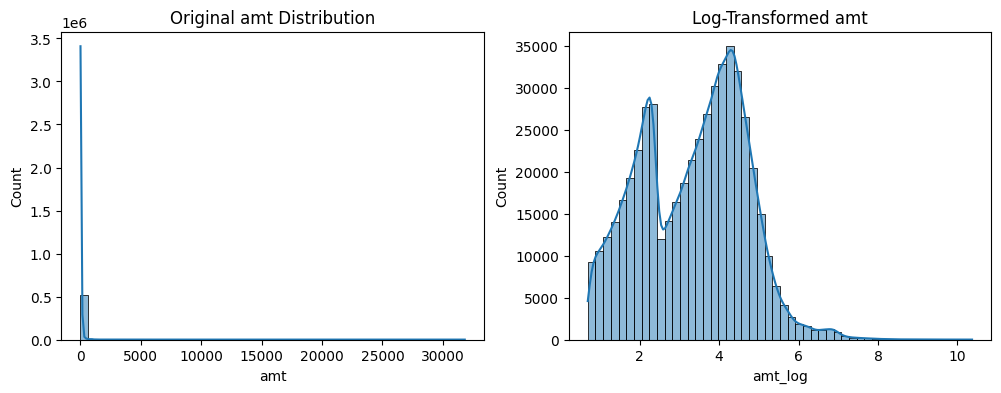

In [ ]:
# --- new amt features ---
df['amt_log'] = np.log1p(df['amt'])
df['is_high_value'] = (df['amt'] > df['amt'].quantile(0.95)).astype(int)
df['amt_per_age'] = df['amt'] / (df['age'] + 1)
df['amt_to_city_pop'] = df['amt'] / (df['city_pop'] + 1)

# --- visual check: distributions before/after ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['amt'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Original amt Distribution')

sns.histplot(df['amt_log'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed amt')

plt.show()


Continuous–Categorical Interaction Summary:

- amt shows significant variation across all categorical groupings — suggesting transaction patterns differ strongly by category and time.
- age and city_pop are also related to categorical variables, likely reflecting demographic and regional structure.
- distance_km shows weaker dependence, indicating it may capture independent spatial effects.
- age and age_group are directly related, and we should keep one of them, based on the model we will choose.

In [25]:
# categorial features to review:
categorical_features = df.select_dtypes(include=['category', 'object']).columns.tolist()
categorical_features

['city',
 'state',
 'category',
 'merchant',
 'trans_month',
 'trans_dayofweek',
 'trans_hour',
 'age_group',
 'location_profile',
 'job_category',
 'category_clean',
 'zip_region',
 'amt_bin',
 'city_pop_bin']

In [20]:
df['category_clean'].unique()

array(['kids_pets', 'home', 'health_fitness', 'travel', 'food_dining',
       'personal_care', 'entertainment', 'shopping_pos', 'shopping_net',
       'gas_transport', 'misc_pos', 'misc_net', 'grocery_pos',
       'grocery_net'], dtype=object)

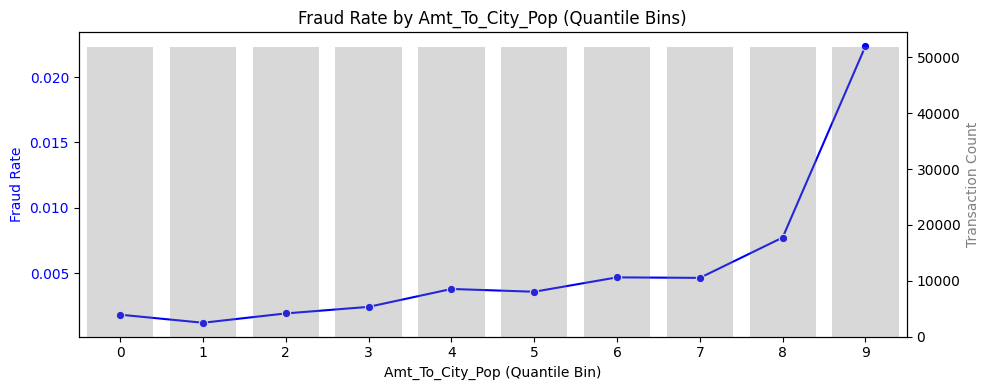

In [16]:
plot_fraud_rate_by_bin(df, 'amt_to_city_pop')

This feature normalizes a customer’s transaction amount by the population of the city they live in.
The idea: a $500 transaction means something different in a city of 10,000 vs 2,000,000.
In small towns, large transactions may stand out — potentially more suspicious.
So, amt_to_city_pop helps the model detect contextual spending anomalies.

If the fraud rate climbs with increasing ratio, the feature is valuable —
it means “big spend in small cities” is more likely fraudulent.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   cc_num               518772 non-null  int64   
 1   city                 518772 non-null  category
 2   state                518772 non-null  category
 3   city_pop             518772 non-null  int64   
 4   acct_num             518772 non-null  int64   
 5   trans_time           518772 non-null  int32   
 6   category             518772 non-null  category
 7   amt                  518772 non-null  float64 
 8   is_fraud             518772 non-null  int64   
 9   merchant             518772 non-null  category
 10  trans_month          518772 non-null  category
 11  trans_day            518772 non-null  int32   
 12  trans_dayofweek      518772 non-null  category
 13  trans_hour           518772 non-null  category
 14  age                  518772 non-null  int64   
 1

In [55]:
df['category_clean'].unique()

array(['kids_pets', 'home', 'health_fitness', 'travel', 'food_dining',
       'personal_care', 'entertainment', 'shopping_pos', 'shopping_net',
       'gas_transport', 'misc_pos', 'misc_net', 'grocery_pos',
       'grocery_net'], dtype=object)

In [ ]:
# --- 1️⃣ Transaction context features ---
df['amt_by_hour'] = df['amt'] * df['trans_hour']
df['amt_by_day'] = df['amt'] * df['trans_dayofweek']
df['amt_by_hour'] = df['amt'] * df['trans_hour']


# --- 2️⃣ Regional context ---
df['amt_per_capita'] = df['amt'] / (df['city_pop'] + 1)  # add +1 to avoid div by zero
df['amt_zip_factor'] = df['amt'] * df['zip_region'].astype('category').cat.codes

# --- 3️⃣ Demographic context ---
age_group_weight = {'young_adults': 0.9, 'adults_2550': 1.0, 'adults_50up': 1.1}
df['amt_age_factor'] = df['amt'] * df['age_group'].map(age_group_weight)
